In [1]:
ROOT = '/home/longhoang01/Developer/table-recognition/data/SciTSR-partition'

In [2]:
import os
import cv2 as cv
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from typing import List
import copy
from tqdm import tqdm

from data_utils.utils import *
from merge.heuristics import *
from adjacency_relation.relation import Relation

### Loading Split ground truths

In [3]:
train_dir = os.path.join(ROOT, 'train')
val_dir = os.path.join(ROOT, 'val')

train_label_path = os.path.join(train_dir, 'label')
val_label_path = os.path.join(val_dir, 'label')

train_split_labels = load_json(os.path.join(train_label_path, 'split_label.json'))
val_split_labels = load_json(os.path.join(val_label_path, 'split_label.json'))

train_chunk_labels = load_json(os.path.join(train_label_path, 'chunk_label.json'))
val_chunk_labels = load_json(os.path.join(val_label_path, 'chunk_label.json'))

len(train_split_labels), len(val_split_labels), len(train_chunk_labels), len(val_chunk_labels)

(10000, 1971, 10000, 1971)

### Calculating the adjacency relation F1

We try to calculate on a single image first

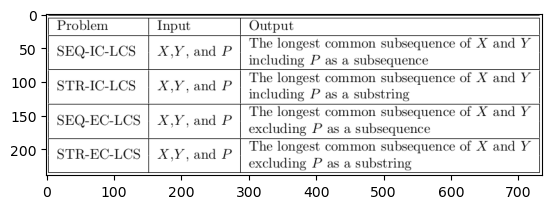

In [4]:
IDX = 68
img_names = list(train_split_labels.keys())
img_name = img_names[IDX]
# img_name = '1507.08539v1.1'
img_name = '1303.1872v1.1'

img_path = os.path.join(train_dir, 'img', img_name + '.png')
img = load_image(img_path)
plt.imshow(img)

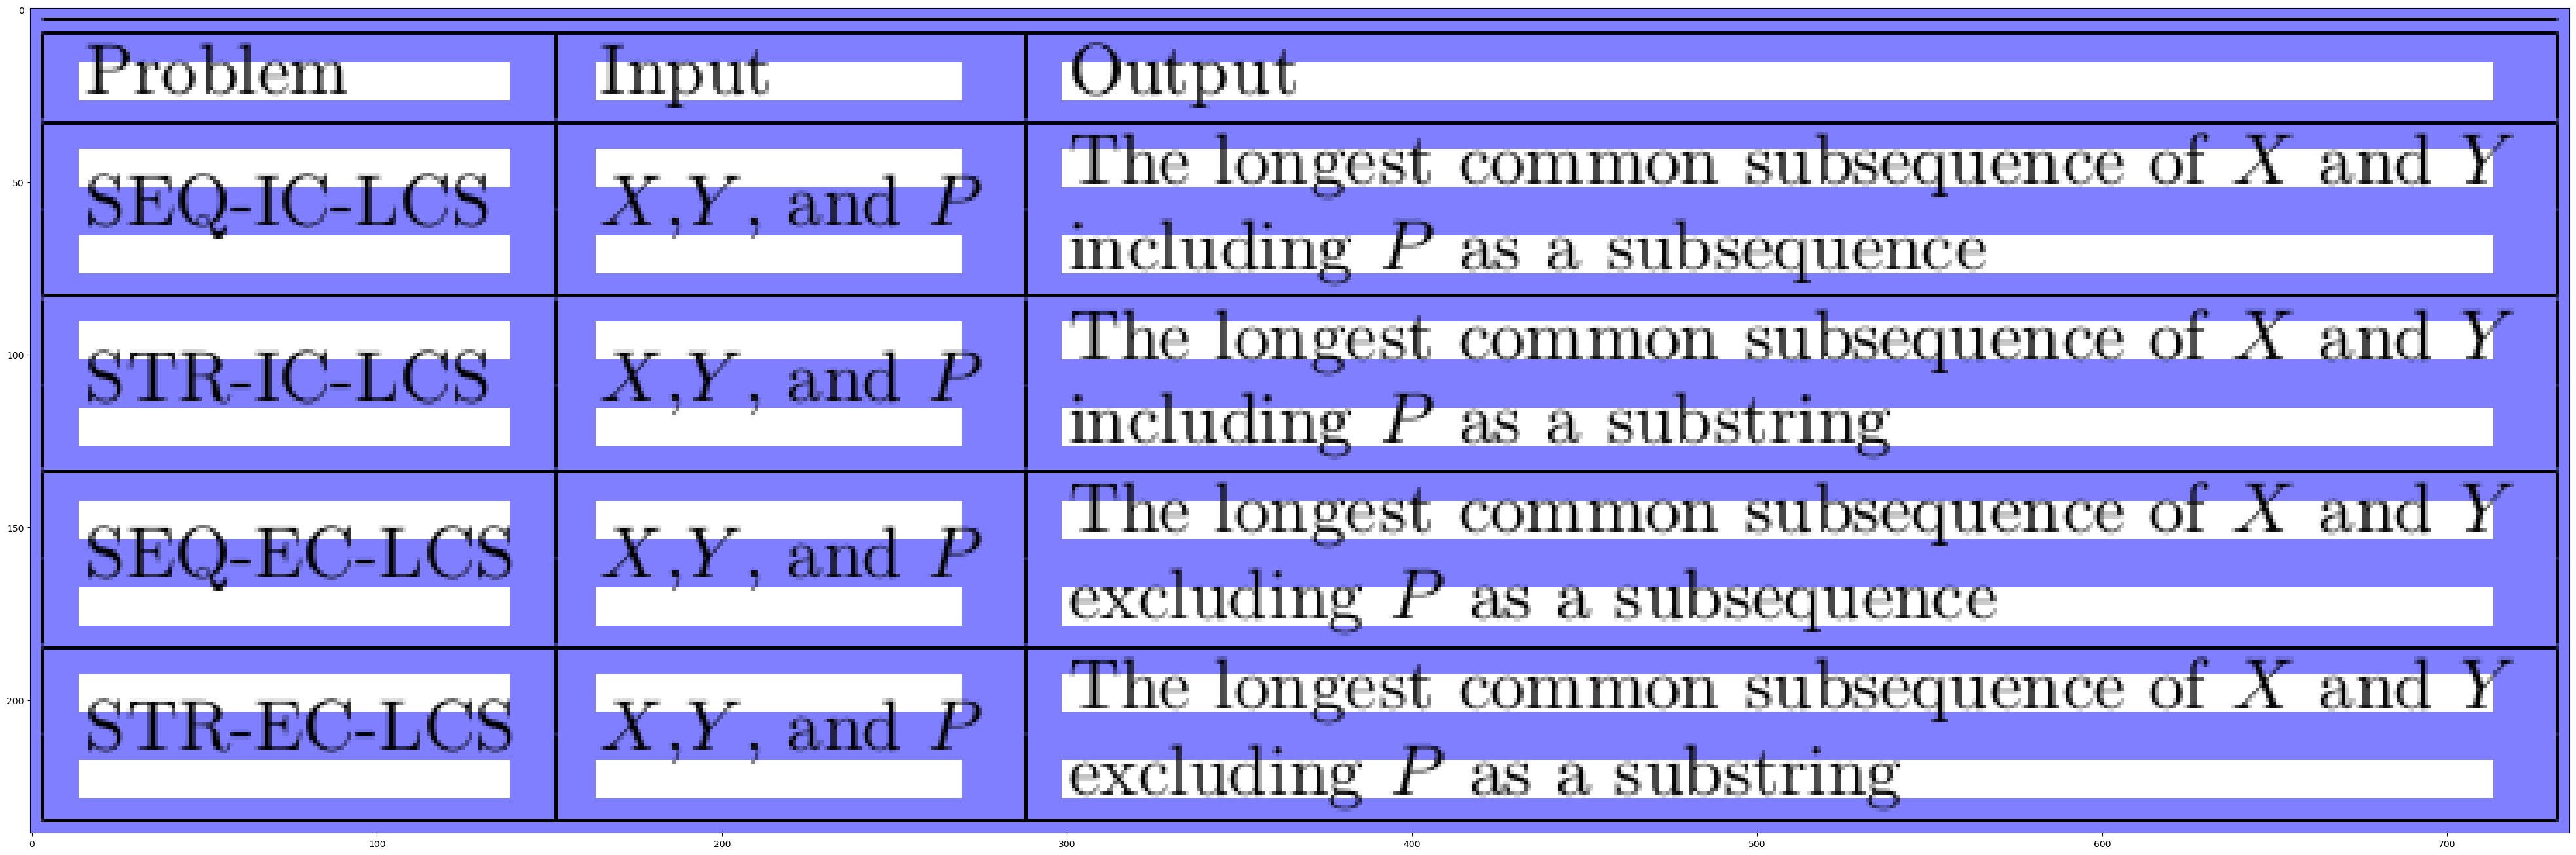

In [5]:
train_merge_labels = load_json(os.path.join(train_label_path, 'merge_label.json'))
val_merge_labels = load_json(os.path.join(val_label_path, 'merge_label.json'))

r_gt, c_gt, R_gt, D_gt = load_merge_gt(train_merge_labels, img_name)
vis_split(img, r_gt, c_gt);

In [6]:
row_gt_idxs, col_gt_idxs = borders(r_gt), borders(c_gt)
cells_gt = get_cells(row_gt_idxs, col_gt_idxs)

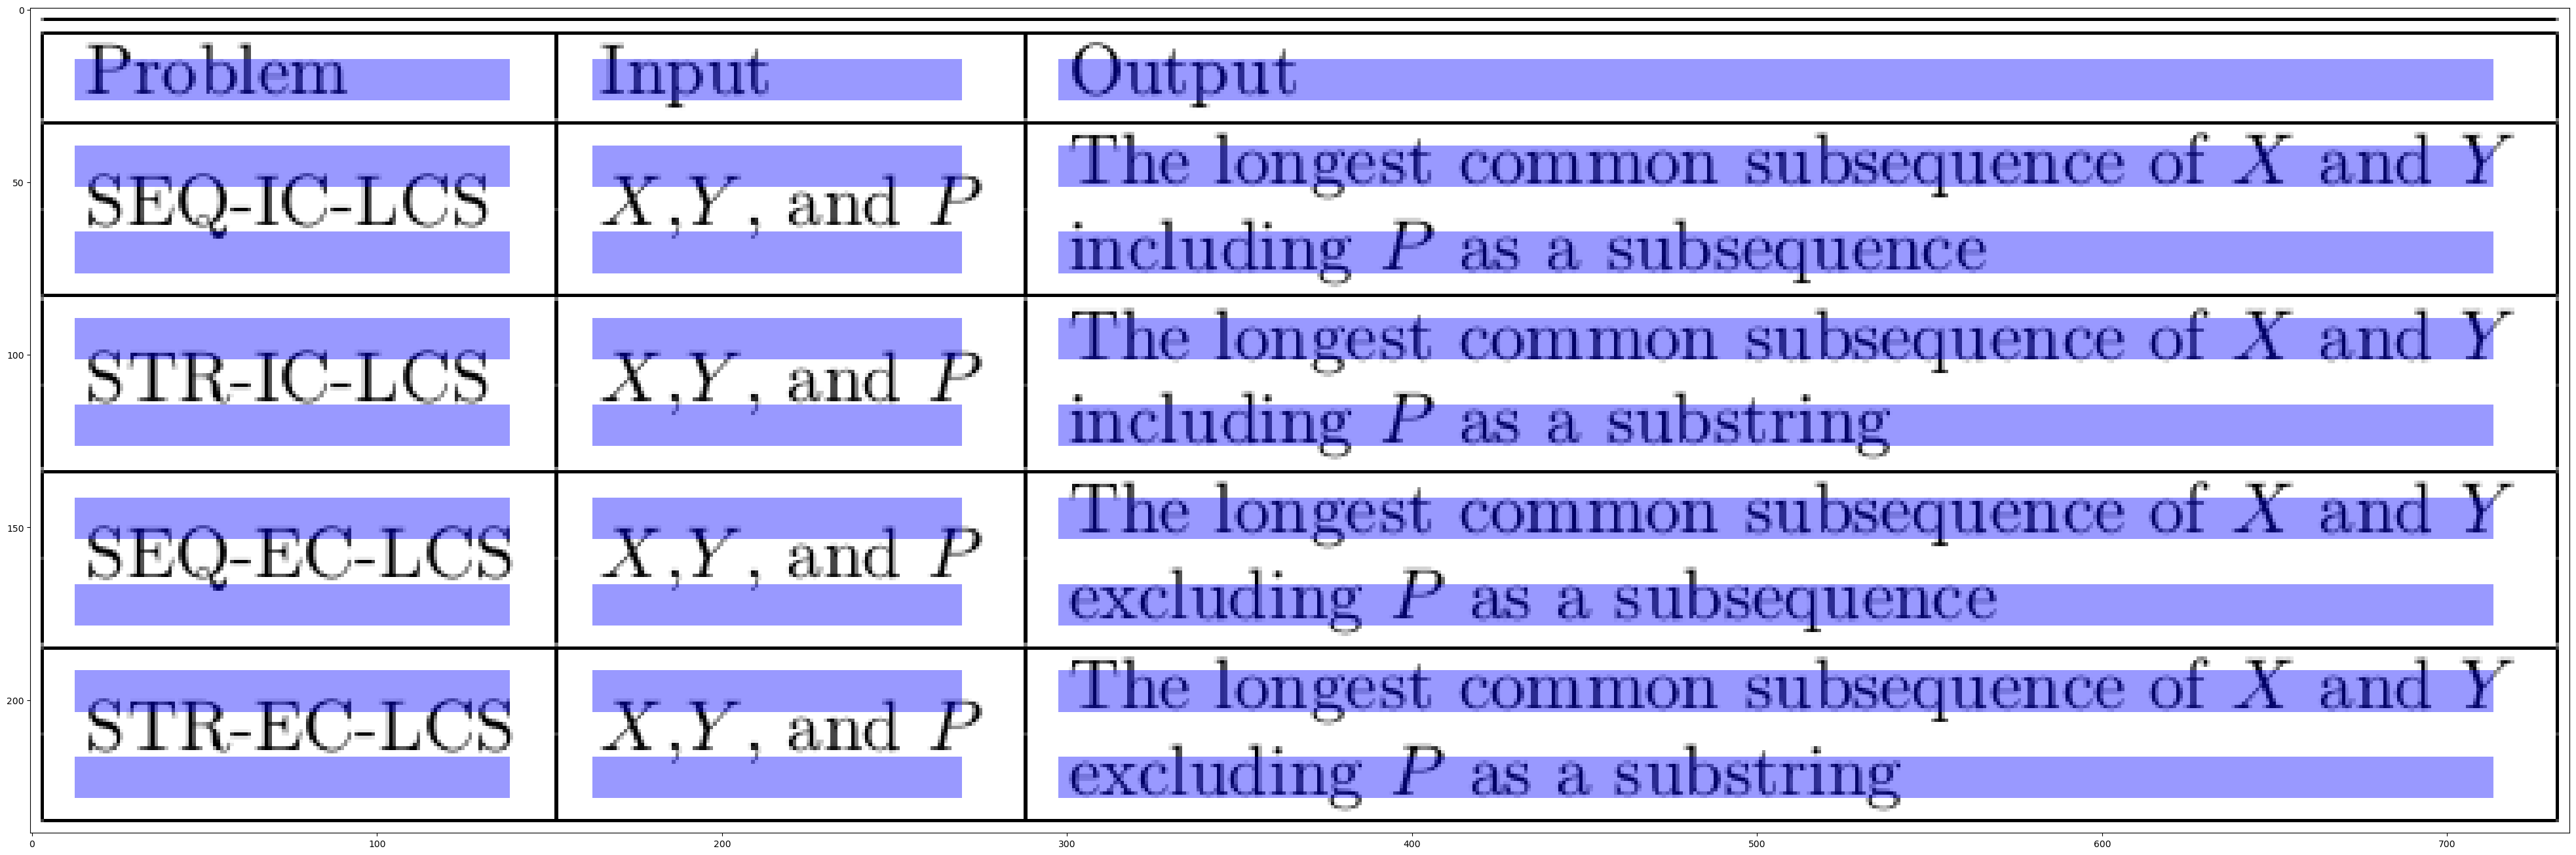

In [7]:
img_boxes = img.copy()
for cell in cells_gt:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 0, 255), -1)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

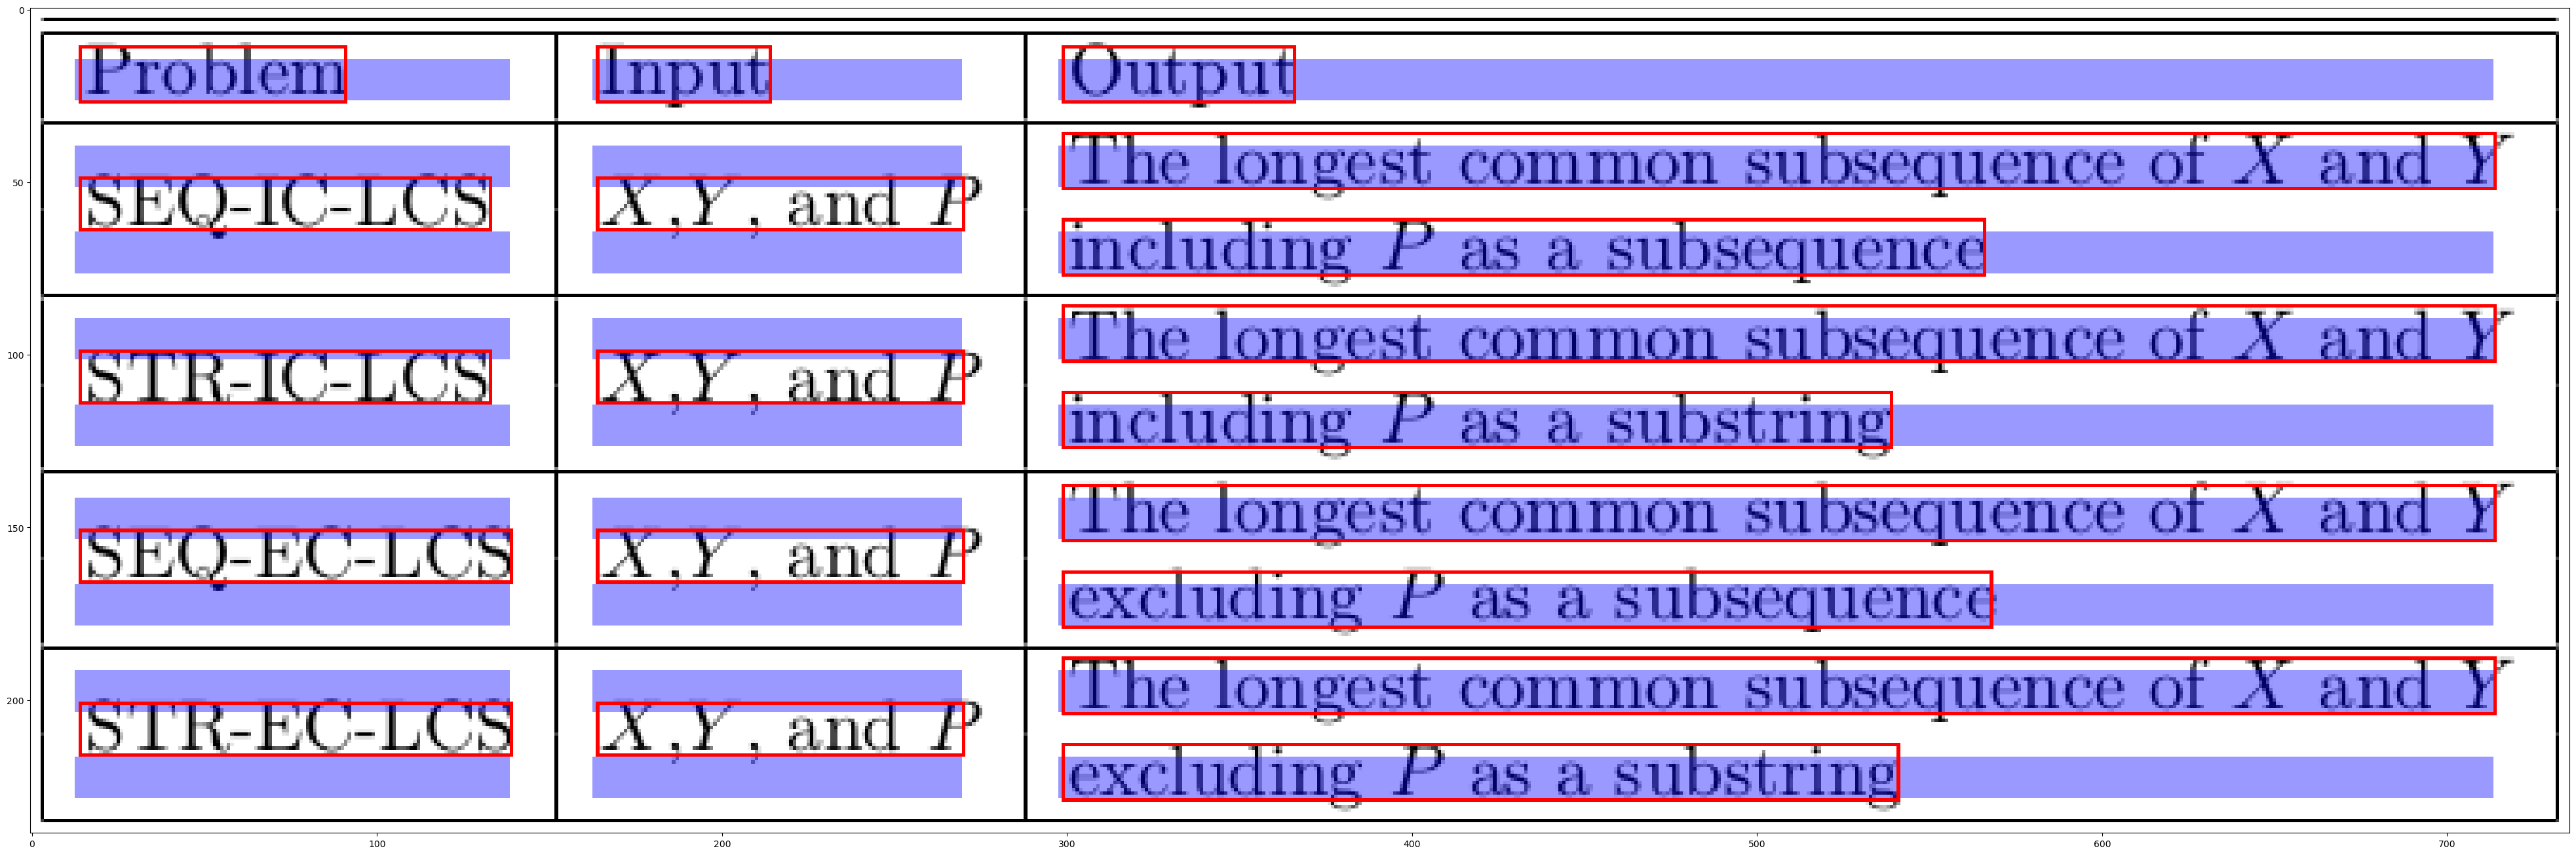

In [8]:
train_chunk_labels = load_json(os.path.join(train_label_path, 'chunk_label.json'))
val_chunk_labels  = load_json(os.path.join(val_label_path, 'chunk_label.json'))

img2 = res.copy()

for text, (l, t, r, b) in train_chunk_labels[img_name]:
    cv.rectangle(img2, (l, t), (r, b), (255, 0, 0), 1)

view_imgs([img2])

In [9]:
cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, verbose=True)

Merge down at cell (1,0)
Merge down at cell (1,1)
Merge down at cell (3,0)
Merge down at cell (3,1)
Merge down at cell (5,0)
Merge down at cell (5,1)
Merge down at cell (7,0)
Merge down at cell (7,1)


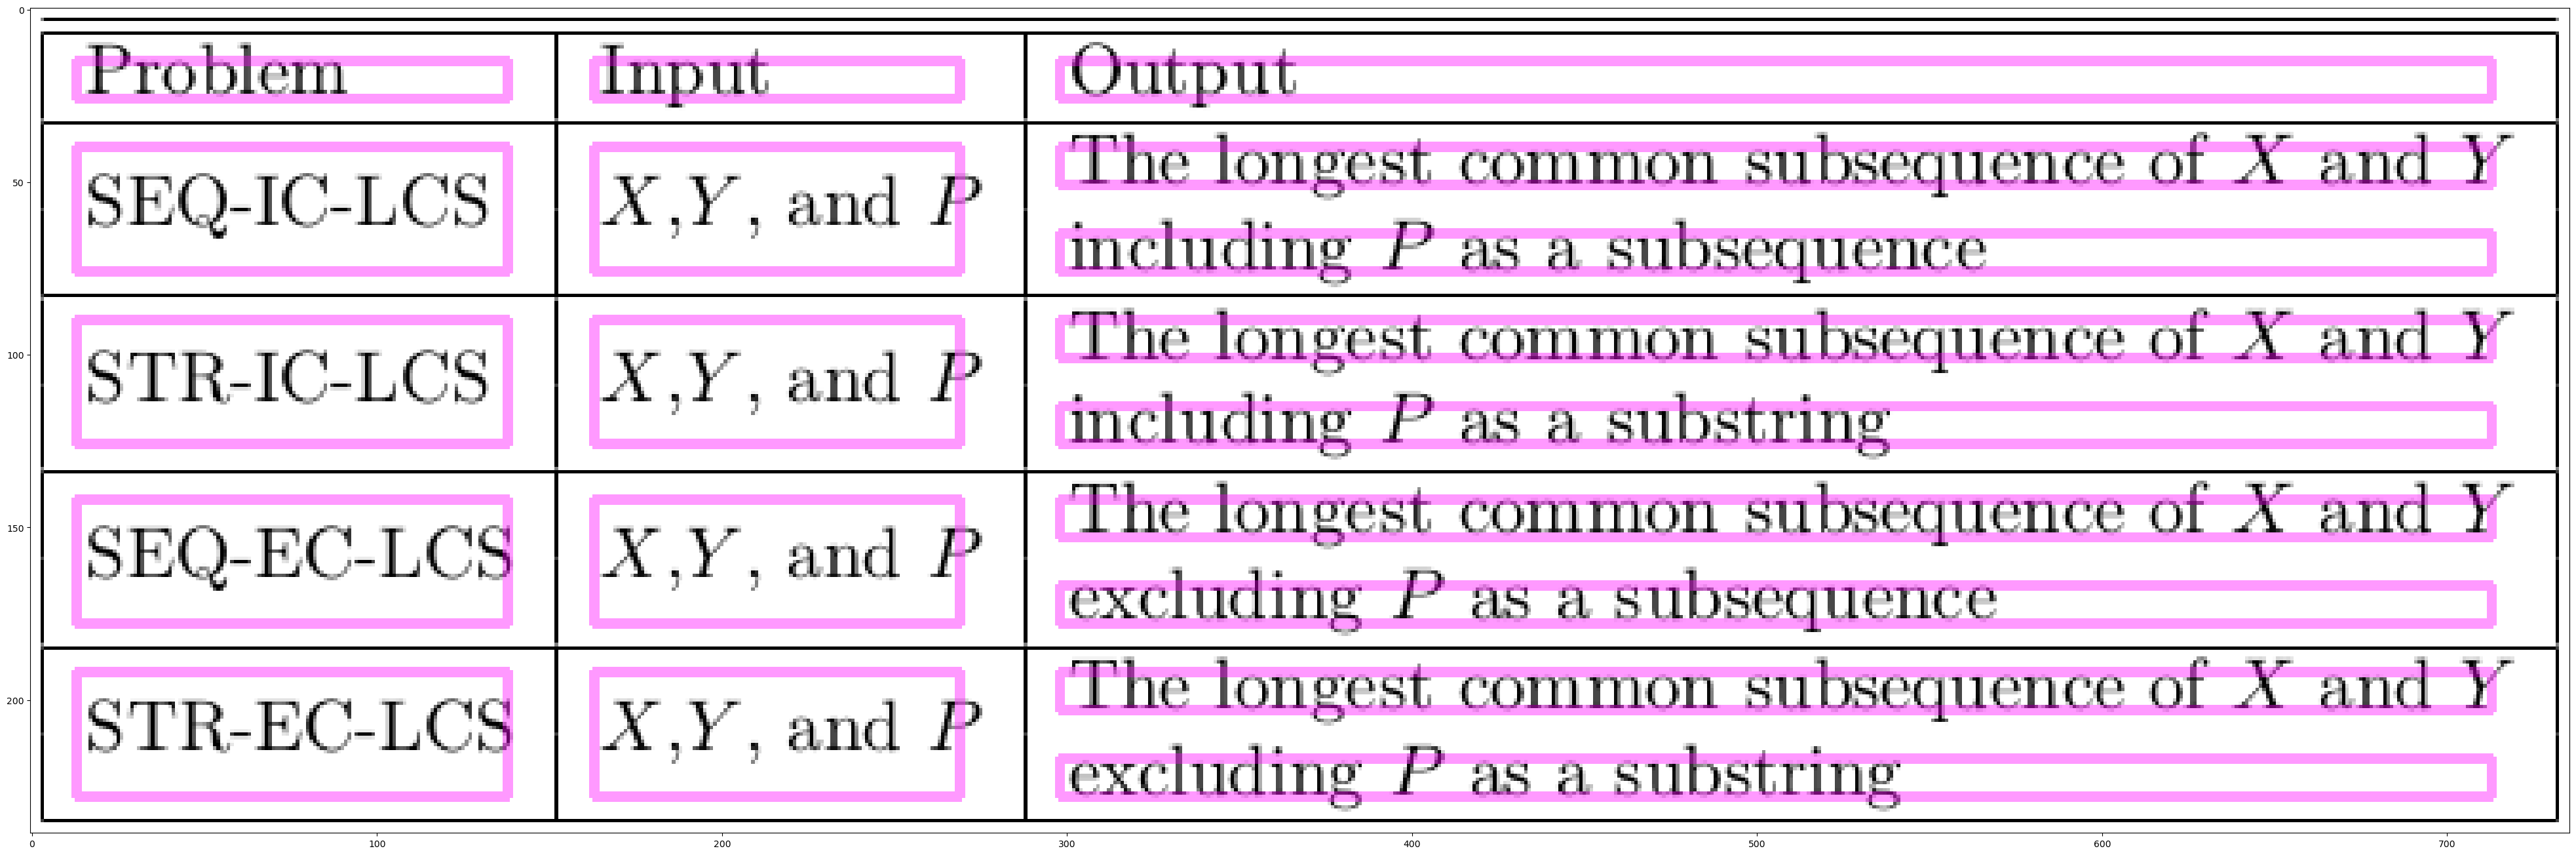

In [10]:
img_boxes = img.copy()
for cell in cells_merged_gt:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (255, 0, 255), 2)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

In [11]:
texts_pos = train_chunk_labels[img_name]
R_pred, D_pred = create_pred_matrices(row_gt_idxs, col_gt_idxs)
rule1(cells_gt, texts_pos, R_pred, D_pred)
rule2(cells_gt, texts_pos, R_pred, D_pred)
cells_merged_pred = merge_cells(cells_gt, R_pred, D_pred, verbose=True)

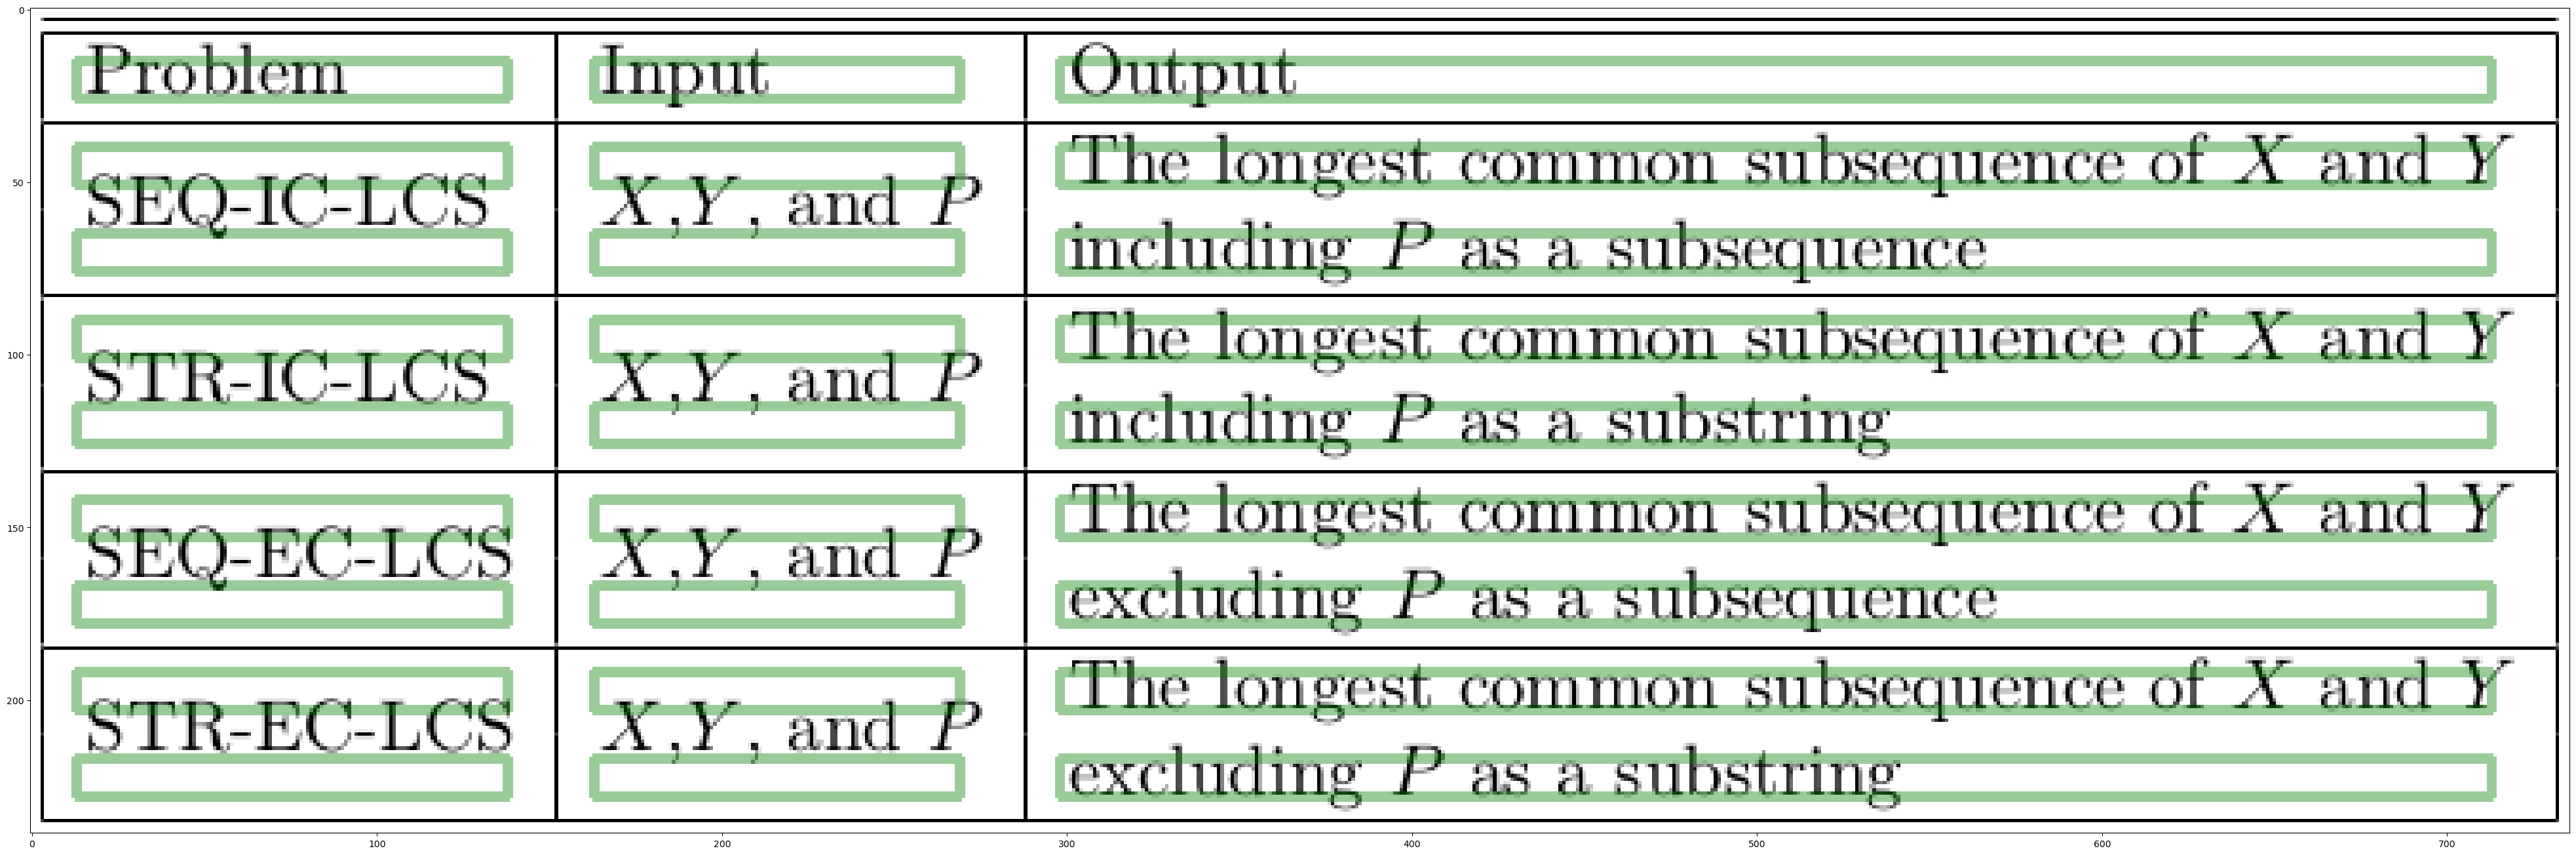

In [12]:
img_boxes = img.copy()
for cell in cells_merged_pred:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 127, 0), 2)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

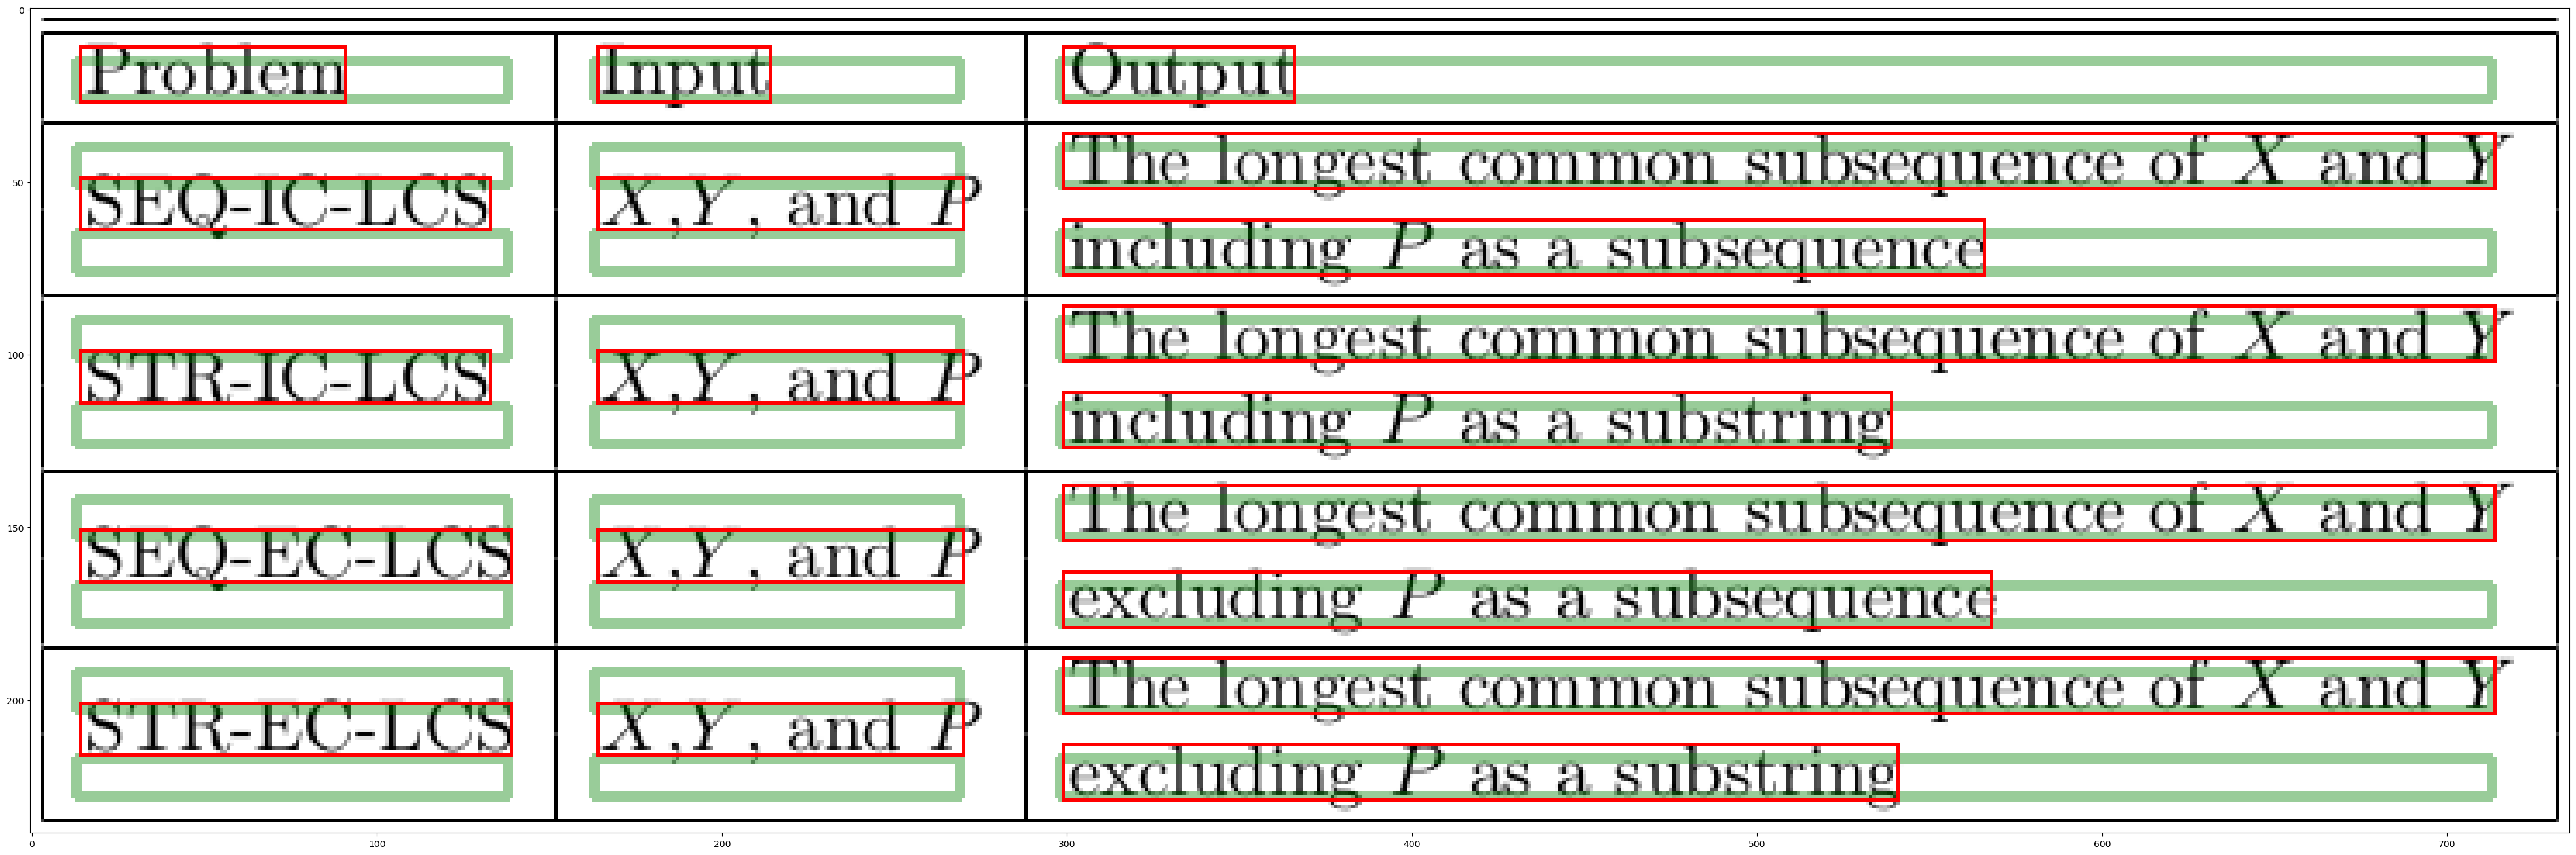

In [13]:
for text, (l, t, r, b) in train_chunk_labels[img_name]:
    cv.rectangle(res, (l, t), (r, b), (255, 0, 0), 1)
view_imgs([res])

In [14]:
len(cells_merged_gt), len(cells_merged_pred)

(19, 27)

Given information:
- List of posistions of ground truth cells (t,l,r,b) in `cells_merged_gt`
- List of positions of predicted cells (t,l,r,b) in `cells_merged_pred`
- List of contents and positions for text (content, (t,l,r,b)) in `texts_pos`

In [15]:
def update_cells_content(cells, texts_pos):
    '''
    Update contents of cells based on positions of texts
    Args:
        cells -- list of Cells
        texts_pos -- contents and positions of texts
    Returns:
        cells -- a deep copy of cells containing texts information
    '''
    cells = copy.deepcopy(cells)
    for cell in cells:
        cell_t, cell_l, cell_b, cell_r = cell.top, cell.left, cell.bottom, cell.right
        for content, (text_l, text_t, text_r, text_b) in texts_pos:
            if (text_l >= cell_l or cell_l - text_l <= 10) and \
                (text_t >= cell_t or cell_t - text_t <= 10) and \
                (text_r <= cell_r or text_r - cell_r <= 10) and \
                (text_b <= cell_b or text_b - cell_b <= 10):
                cell.content = content
    return cells

cells_merged_gt = update_cells_content(cells_merged_gt, texts_pos)
cells_merged_pred = update_cells_content(cells_merged_pred, texts_pos)

In [16]:
RIGHT = 1
DOWN = 2

def find_right_relations(cell, cells_list, processed_cells=set(), root=None, n_steps=0):
    rels = []
    
    # Check if the cell has already been processed
    if cell in processed_cells:
        return rels
    
    processed_cells.add(cell)  # Mark the cell as processed

    right_neighbor_l = min((c.left for c in cells_list if c.left >= cell.right), default=None)
    candidates = [c for c in cells_list 
                  if (c.left == right_neighbor_l and c.top >= cell.top and c.bottom <= cell.bottom)]

    if root is None:
        root = cell 
    for cand in candidates:
        if cand.content is not None:
            rels.append(Relation(root.content, cand.content, RIGHT, n_blanks=n_steps))
        else:
            # Find the right relations of this candidate with empty content
            empty_relations = find_right_relations(cand, cells_list, processed_cells, root, n_steps+1)
            rels.extend(empty_relations)

    return rels

def find_down_relations(cell, cells_list, processed_cells=set(), root=None, n_steps=0):
    rels = []
    
    # Check if the cell has already been processed
    if cell in processed_cells:
        return rels
    
    processed_cells.add(cell)  # Mark the cell as processed

    down_neighbor_t = min((c.top for c in cells_list if c.top >= cell.bottom), default=None)
    candidates = [c for c in cells_list
                  if (c.top == down_neighbor_t and c.left >= cell.left and c.right <= cell.right)]

    if root is None:
        root = cell
    for cand in candidates:
        if cand.content is not None:
            rels.append(Relation(root.content, cand.content, DOWN, n_blanks=n_steps))
        else:
            # Find the down relations of this candidate with empty content
            empty_relations = find_down_relations(cand, cells_list, processed_cells, root, n_steps+1)
            rels.extend(empty_relations)

    return rels

TODO: there is one current error with this two functions, relations found here for this cell won't appear later in the entire list of relations. Could be because of recursion, check again

In [17]:
# find_right_relations(cells_merged_pred[1], cells_merged_pred)

In [18]:
# find_down_relations(cells_merged_pred[1], cells_merged_pred)

In [19]:
def cells2relations(cells_list):
    '''
    Convert cells into relations
    Args:
        cells_list -- list of Cells containing texts information
    Returns:
        rels -- list of Relations
    '''
    rels = []
    for cell in cells_list:
        if cell.content is None:
            continue
        rels.extend(find_right_relations(cell, cells_list))
        rels.extend(find_down_relations(cell, cells_list))
    return rels

In [20]:
rels_gt = cells2relations(cells_merged_gt)
rels_gt

[Relation(Problem, Input, RIGHT, n_blanks=0),
 Relation(Problem, SEQ-IC-LCS, DOWN, n_blanks=0),
 Relation(Input, Output, RIGHT, n_blanks=0),
 Relation(Input, X,Y,andP, DOWN, n_blanks=0),
 Relation(Output, ThelongestcommonsubsequenceofXandY, DOWN, n_blanks=0),
 Relation(SEQ-IC-LCS, X,Y,andP, RIGHT, n_blanks=0),
 Relation(SEQ-IC-LCS, STR-IC-LCS, DOWN, n_blanks=0),
 Relation(X,Y,andP, ThelongestcommonsubsequenceofXandY, RIGHT, n_blanks=0),
 Relation(X,Y,andP, includingPasasubsequence, RIGHT, n_blanks=0),
 Relation(X,Y,andP, X,Y,andP, DOWN, n_blanks=0),
 Relation(ThelongestcommonsubsequenceofXandY, includingPasasubsequence, DOWN, n_blanks=0),
 Relation(includingPasasubsequence, ThelongestcommonsubsequenceofXandY, DOWN, n_blanks=0),
 Relation(STR-IC-LCS, X,Y,andP, RIGHT, n_blanks=0),
 Relation(STR-IC-LCS, SEQ-EC-LCS, DOWN, n_blanks=0),
 Relation(X,Y,andP, ThelongestcommonsubsequenceofXandY, RIGHT, n_blanks=0),
 Relation(X,Y,andP, includingPasasubstring, RIGHT, n_blanks=0),
 Relation(X,Y,and

In [21]:
rels_pred = cells2relations(cells_merged_pred)
rels_pred

[Relation(Problem, Input, RIGHT, n_blanks=0),
 Relation(Input, Output, RIGHT, n_blanks=0),
 Relation(Output, ThelongestcommonsubsequenceofXandY, DOWN, n_blanks=0),
 Relation(ThelongestcommonsubsequenceofXandY, includingPasasubsequence, DOWN, n_blanks=0),
 Relation(includingPasasubsequence, ThelongestcommonsubsequenceofXandY, DOWN, n_blanks=0),
 Relation(ThelongestcommonsubsequenceofXandY, includingPasasubstring, DOWN, n_blanks=0),
 Relation(includingPasasubstring, ThelongestcommonsubsequenceofXandY, DOWN, n_blanks=0),
 Relation(ThelongestcommonsubsequenceofXandY, excludingPasasubsequence, DOWN, n_blanks=0),
 Relation(excludingPasasubsequence, ThelongestcommonsubsequenceofXandY, DOWN, n_blanks=0),
 Relation(ThelongestcommonsubsequenceofXandY, excludingPasasubstringg, DOWN, n_blanks=0)]

In [22]:
def compare_relations(rels_pred, rels_gt, compare_blanks=True):
    '''
    Count the number of correct relation predictions
    Args:
        rels_pred -- list of predicted relations
        rels_gt -- list of ground truth relations
        compare_blanks -- boolean, whether to take the number of blank cells into account
    Returns:
        cnt -- number of correct predicted relations
    '''
    dup_rels_pred = copy.deepcopy(rels_pred)
    cnt = 0
    for rgt in rels_gt:
        to_rm = None
        for i, rp in enumerate(dup_rels_pred):
            if rgt.equal(rp, compare_blanks):
                to_rm = i
                cnt += 1
                break

        if to_rm is not None:
            dup_rels_pred = dup_rels_pred[:i] + dup_rels_pred[i:]

    return cnt

In [23]:
compare_relations(rels_pred, rels_gt), len(rels_pred), len(rels_gt)

(10, 10, 30)

In [24]:
def eval_relations_macro(gt, pred, cmp_blanks=True):
    '''
    Calculate precision, recall, and F1 score at macro level
    Args:
        pred -- a list of lists of Relations from prediction (for all table images where each image contains a list of Relations)
        gt -- a list of lists of Relations from ground truth
    Returns:
        res -- dictionary containing 3 keys: 'prec', 'rec', 'f1'
    '''
    tot_prec, tot_rec, cnt = 0, 0, 0
    assert len(pred) == len(gt)

    for preds, gts in zip(pred, gt):
        n_correct = compare_relations(preds, gts, cmp_blanks)
        prec = n_correct / len(preds) if len(preds) != 0 else 0
        rec = n_correct / len(gts) if len(gts) != 0 else 0
        tot_prec += prec
        tot_rec += rec
        cnt += 1

    precision = tot_prec / cnt if cnt != 0 else 0
    recall = tot_rec / cnt if cnt != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return {'prec': precision, 'rec': recall, 'f1': f1}

def eval_relations_micro(gt, pred, cmp_blanks=True):
    '''
    Calculate precision, recall, and F1 score at micro level
    Args:
        pred -- a list of lists of Relations from prediction (for all table images where each image contains a list of Relations)
        gt -- a list of lists of Relations from ground truth
    Returns:
        res -- dictionary containing 3 keys: 'prec', 'rec', 'f1'
    '''
    TP, FP, FN = 0, 0, 0

    assert len(pred) == len(gt)

    for preds, gts in zip(pred, gt):
        n_correct = compare_relations(preds, gts, cmp_blanks)
        TP += n_correct
        FP += (len(preds) - n_correct)
        FN += (len(gts) - n_correct)

    # Handle the case when both predicted and ground truth lists are empty
    if TP == 0 and FP == 0 and FN == 0:
        precision, recall, f1 = 0.0, 0.0, 0.0
    else:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {'prec': precision, 'rec': recall, 'f1': f1}

Putting everything together

In [25]:
import pickle

def save_pickle(obj, save_path):
    with open(save_path, 'wb') as f:
        pickle.dump(obj, f)
    print(f'Data saved to {save_path}')

def load_pickle(load_path):
    with open(load_path, 'rb') as f:
        data = pickle.load(f)
    print(f'Data loaded from {load_path}')
    return data

In [26]:
def write_list_txt(file_path, string_list):
    """
    Write a list of strings to a text file, with each string on a new line.

    Parameters:
    - file_path (str): The path to the text file.
    - string_list (list): The list of strings to be written to the file.
    """
    try:
        with open(file_path, 'w') as file:
            for string in string_list:
                file.write(str(string) + '\n')
        print(f"Successfully wrote {len(string_list)} lines to {file_path}")
    except Exception as e:
        print(f"Error writing to {file_path}: {e}")

def process_relations(part_dir, save_path=None, error_path=None, selected_images=None):
    '''
    Args:
        part_dir -- partitioned directory. Could be 'train', 'val', or 'test'
        save_path -- path to save result as pickle file
    Returns:
        gt -- list of list of Relations
        pred -- list of list of Relations
    '''
    RIGHT = 1
    DOWN = 2
    error_names = []

    part_label_dir = os.path.join(part_dir, 'label')
    split_labels = load_json(os.path.join(part_label_dir, 'split_label.json'))
    merge_labels = load_json(os.path.join(part_label_dir, 'merge_label.json'))
    chunk_labels = load_json(os.path.join(part_label_dir, 'chunk_label.json'))

    img_names = list(split_labels.keys())
    res = {}
    for img_name in tqdm(img_names, desc='Image'):
        # print(img_name)
        if selected_images is not None and img_name not in selected_images:
            continue
        
        # ground truth
        r_gt, c_gt, R_gt, D_gt = load_merge_gt(merge_labels, img_name)
        row_gt_idxs, col_gt_idxs = borders(r_gt), borders(c_gt)
        cells_gt = get_cells(row_gt_idxs, col_gt_idxs)
        cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, verbose=False)
        if cells_merged_gt is None:
            error_names.append(img_name)
            continue
        
        # prediction
        texts_pos = chunk_labels[img_name]
        R_pred, D_pred = create_pred_matrices(row_gt_idxs, col_gt_idxs)
        rule1(cells_gt, texts_pos, R_pred, D_pred)
        rule2(cells_gt, texts_pos, R_pred, D_pred)
        cells_merged_pred = merge_cells(cells_gt, R_pred, D_pred, verbose=False)
        
        # adjacency relation
        cells_merged_gt = update_cells_content(cells_merged_gt, texts_pos)
        cells_merged_pred = update_cells_content(cells_merged_pred, texts_pos)
        rels_gt = cells2relations(cells_merged_gt)
        rels_pred = cells2relations(cells_merged_pred)
        res[img_name] = {
            'gt': rels_gt, 'pred': rels_pred, 
            'cells_split': cells_gt,
            'cells_gt': cells_merged_gt, 'celss_pred': cells_merged_pred
        }
        
    print('Finished processing relations')
    if save_path is not None:
        save_pickle(res, save_path)

    if error_path is not None:
        print(f'Found {len(error_names)}/{len(img_names)} images with label error stored at {error_path}')
        write_list_txt(error_path, error_names)
    return res

In [27]:
save_path = '/home/longhoang01/Developer/table-recognition/results/adj-rel/train_gt/res.pkl'

selected_images = [
    '1604.03099v1.2',
    '1804.03343v1.8',
    '1801.00693v1.3',
    '0409023v2.1',
    '1712.03781v2.6',
    '1605.09721v1.1',
    '1608.04337v2.1',
    '1303.1872v1.1',
    '1804.03343v1.6',
    '1712.00848v1.1'
]

res = process_relations(
    train_dir, 
    save_path=save_path,
    # error_path='/home/longhoang01/Developer/table-recognition/error/adj_rel_errors.txt'
    error_path=None,
    selected_images=selected_images
)
res = load_pickle(save_path)

Image: 100%|██████████| 10000/10000 [00:00<00:00, 19227.26it/s]

Finished processing relations
Data saved to /home/longhoang01/Developer/table-recognition/results/adj-rel/train_gt/res.pkl
Data loaded from /home/longhoang01/Developer/table-recognition/results/adj-rel/train_gt/res.pkl


In [28]:
def top_n_lowest(res, n=10):
    result = {}
    for img_name, val in res.items():
        gt, pred = val['gt'], val['pred']
        cells_gt, cells_pred = val['cells_gt'], val['celss_pred']
        cells_split = val['cells_split']
        f1 = eval_relations_macro([gt], [pred])['f1']
        result[img_name] = {
            'f1': f1, 
            'cells_split': cells_split,
            'cells_pred': cells_pred, 
            'cells_gt': cells_gt}
    sorted_result = sorted(result.items(), key=lambda x: x[1]['f1'])
    n = min(n, len(sorted_result))
    return dict(sorted_result[:n])

top_n = top_n_lowest(res)
# top_n

1604.03099v1.2 | f1: 0.20512820512820512


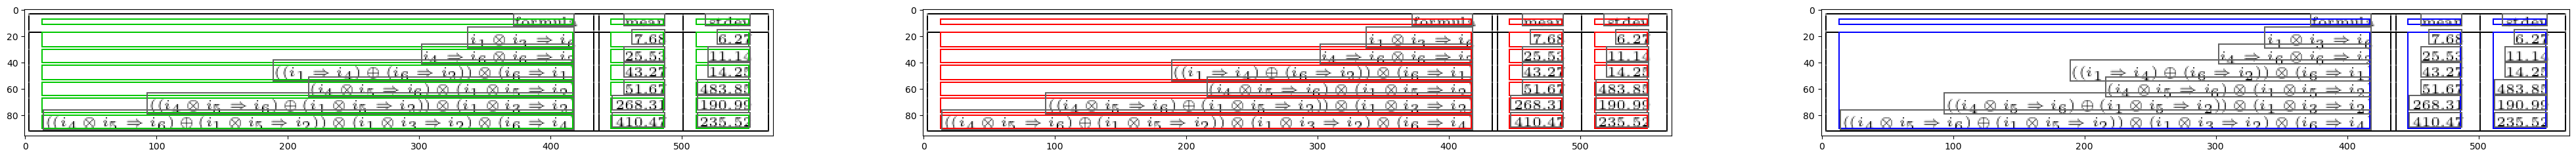

1804.03343v1.8 | f1: 0.2857142857142857


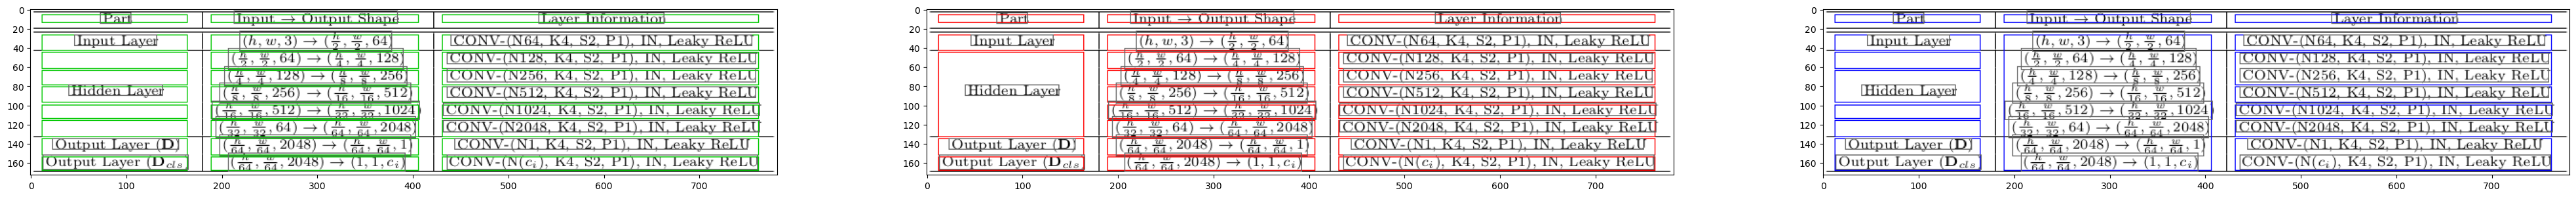

1801.00693v1.3 | f1: 0.28571428571428575


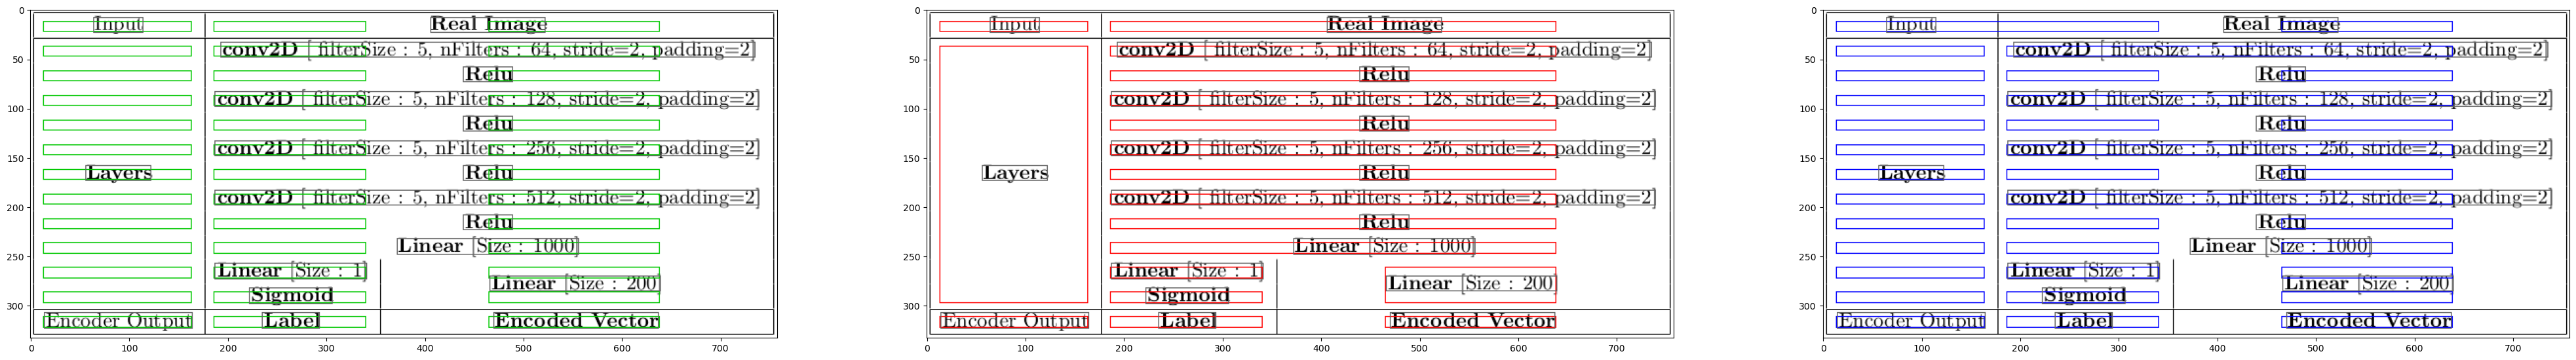

0409023v2.1 | f1: 0.3181818181818182


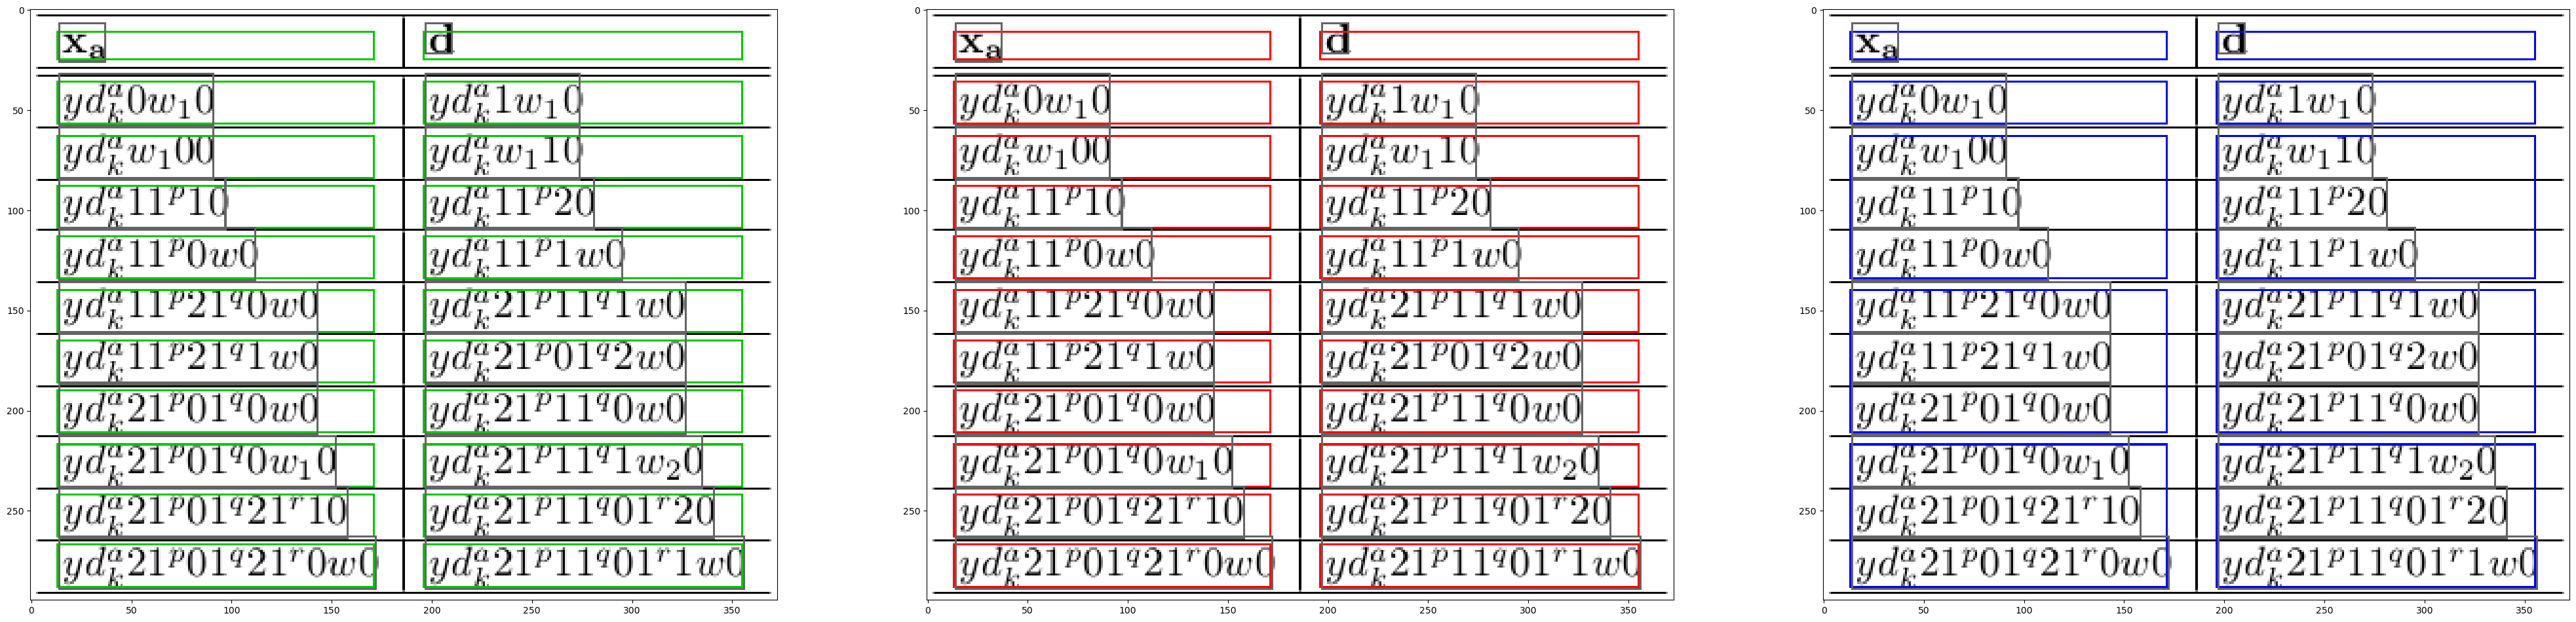

1712.03781v2.6 | f1: 0.41935483870967744


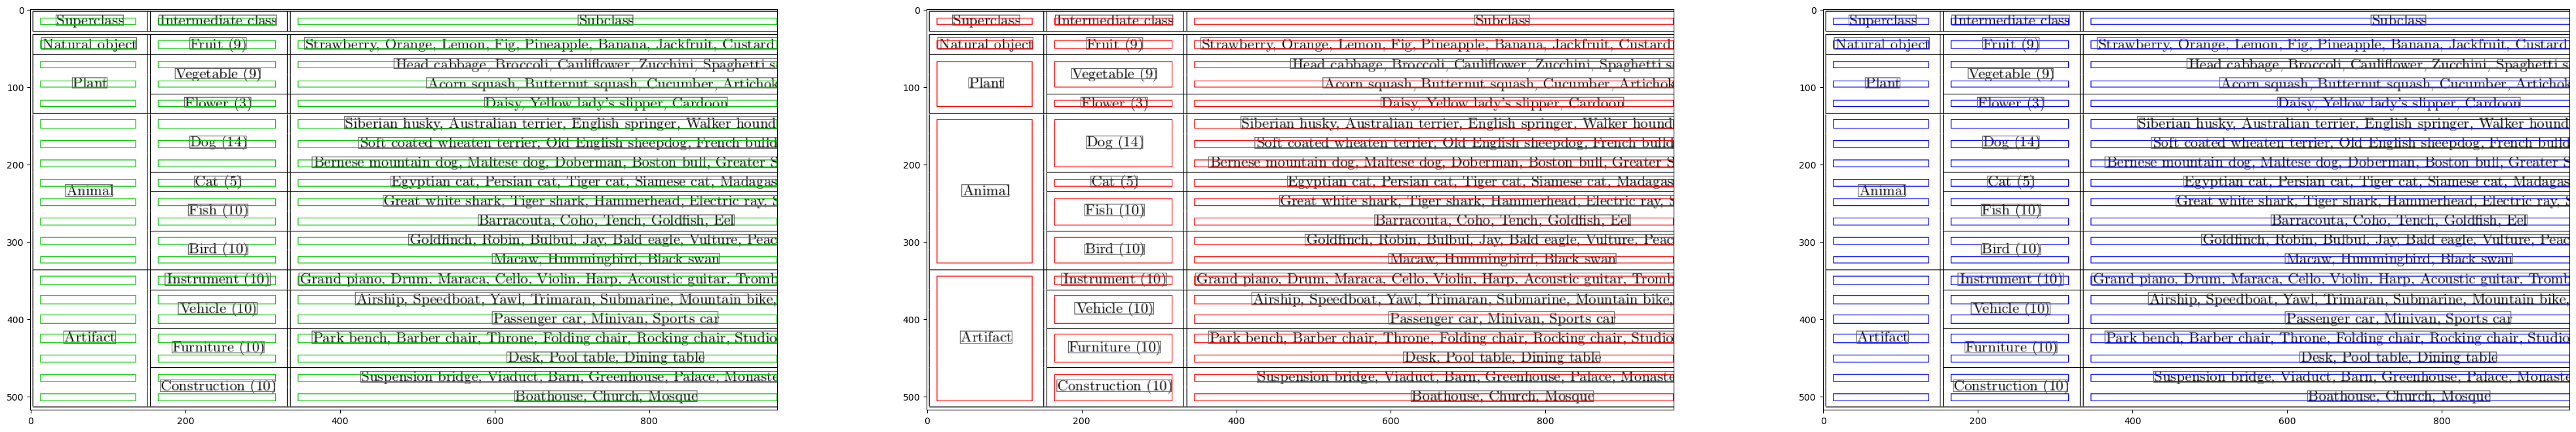

1605.09721v1.1 | f1: 0.4225352112676057


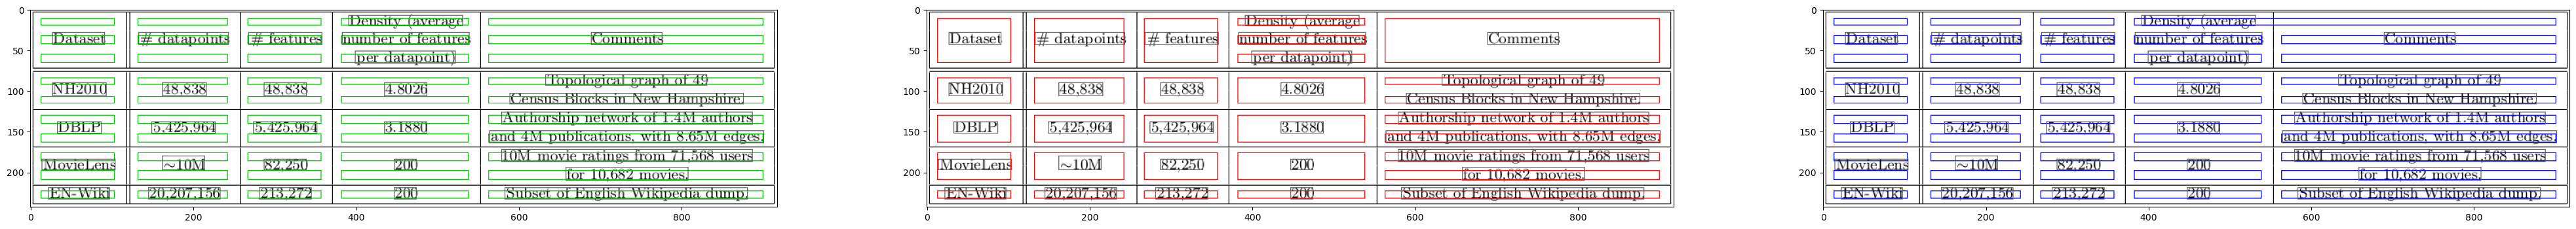

1608.04337v2.1 | f1: 0.4838709677419355


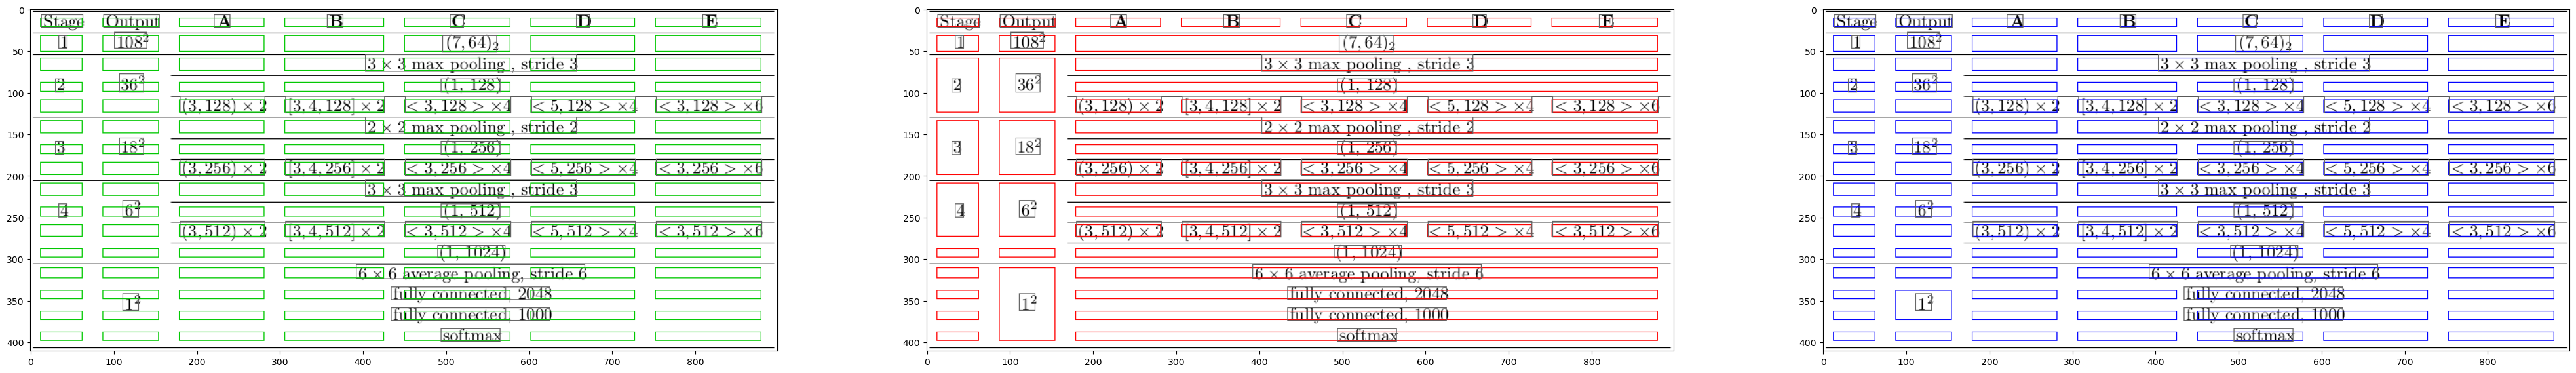

1303.1872v1.1 | f1: 0.5


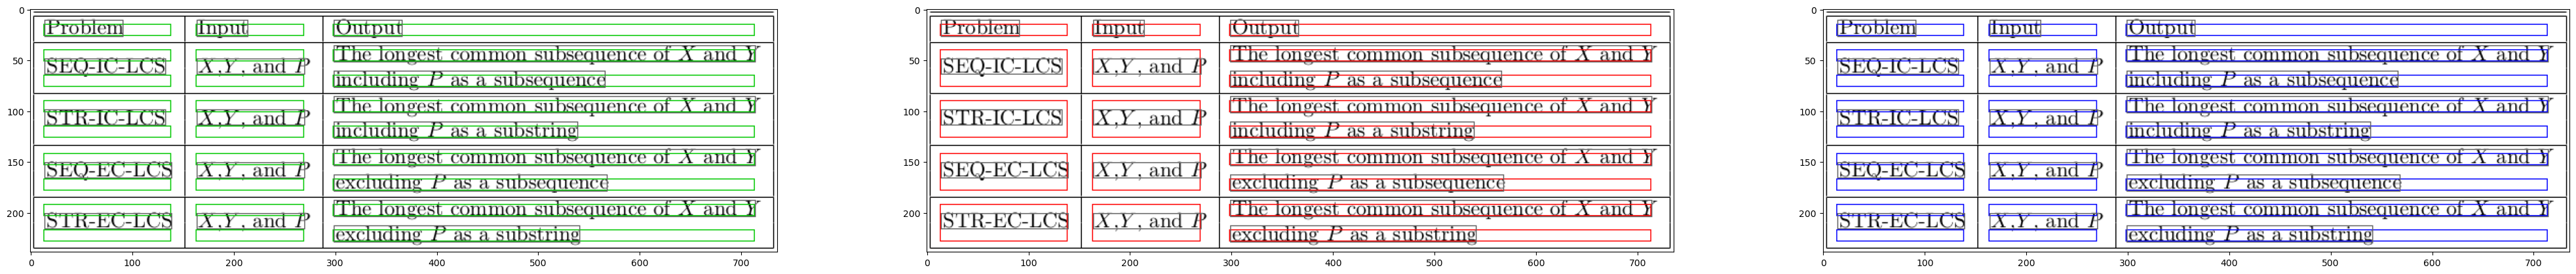

1804.03343v1.6 | f1: 0.5084745762711864


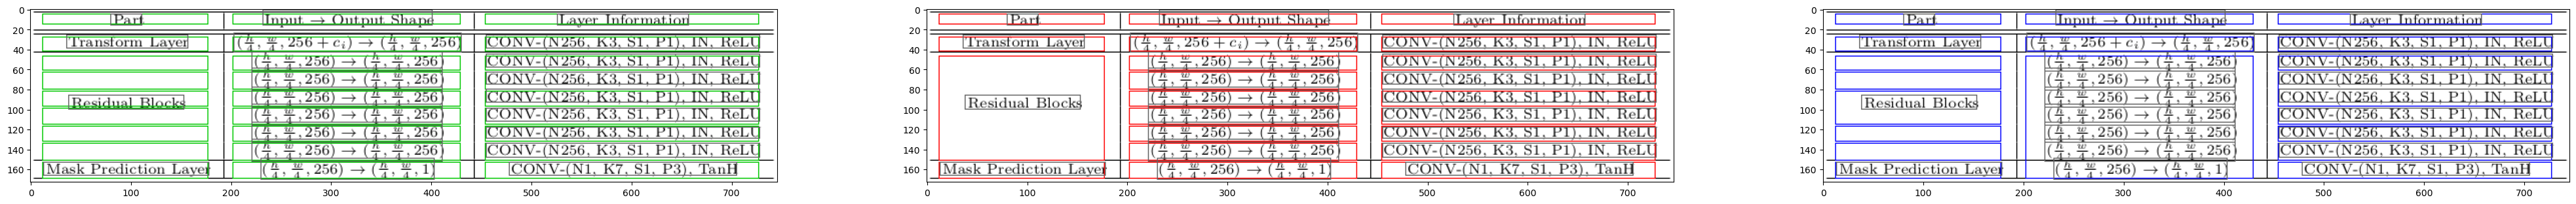

1712.00848v1.1 | f1: 0.5142857142857143


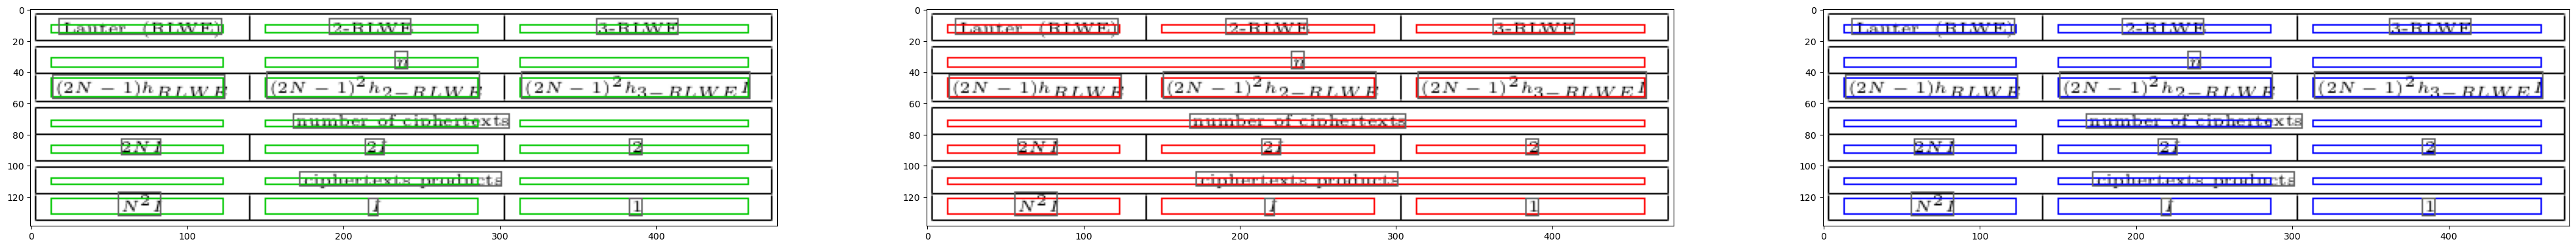

In [29]:
def vis_top_n(img_dir, top_n, save_dir, chunk_labels):
    for img_name, val in top_n.items():
        img = load_image(os.path.join(img_dir, f'{img_name}.png'))

        img_split = vis_cells(img, val['cells_split'], 'green')
        img_split = vis_chunks(img_split, chunk_labels[img_name])

        img_gt = vis_cells(img, val['cells_gt'], 'red')
        img_gt = vis_chunks(img_gt, chunk_labels[img_name])

        img_pred = vis_cells(img,val['cells_pred'])
        img_pred = vis_chunks(img_pred, chunk_labels[img_name])
        print(f'{img_name} | f1: {val['f1']}')
        view_imgs([img_split, img_gt, img_pred])

        this_dir = os.path.join(save_dir, img_name)
        os.makedirs(this_dir, exist_ok=True)

        cv.imwrite(
            os.path.join(this_dir, 'split_gt.png'), 
            cv.cvtColor(img_split, cv.COLOR_RGB2BGR)
        )
        cv.imwrite(
            os.path.join(this_dir, 'merge_gt.png'), 
            cv.cvtColor(img_gt, cv.COLOR_RGB2BGR)
        )
        cv.imwrite(
            os.path.join(this_dir, 'merge_pred.png'),
            cv.cvtColor(img_pred, cv.COLOR_RGB2BGR)
        )

merge_path = '/home/longhoang01/Developer/table-recognition/results/merge2'
vis_top_n(os.path.join(train_dir, 'img'), top_n, merge_path, train_chunk_labels)

In [31]:
[key for key, val in top_n.items()]

['1604.03099v1.2',
 '1804.03343v1.8',
 '1801.00693v1.3',
 '0409023v2.1',
 '1712.03781v2.6',
 '1605.09721v1.1',
 '1608.04337v2.1',
 '1303.1872v1.1',
 '1804.03343v1.6',
 '1712.00848v1.1']

In [27]:
res_macro = eval_relations_macro(gt, pred)
res_macro['prec'], res_macro['rec'], res_macro['f1']

(0.9949456103030967, 0.985045506336018, 0.9899708076886743)

In [28]:
res_micro = eval_relations_micro(gt, pred)
res_micro['prec'], res_micro['rec'], res_micro['f1']

(0.994642494736041, 0.984162718458787, 0.9893748560866288)

In [29]:
val_gt, val_pred = process_relations(val_dir, error_path='/Users/longhoang/Developer/table-recognition/error/adj_rel_errors.txt')

Image:   2%|▏         | 44/1971 [00:00<00:14, 134.42it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   4%|▎         | 70/1971 [00:00<00:17, 110.61it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:   6%|▌         | 117/1971 [00:01<00:23, 80.56it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  10%|█         | 204/1971 [00:03<00:23, 74.26it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  12%|█▏        | 231/1971 [00:03<00:19, 89.29it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  13%|█▎        | 256/1971 [00:03<00:18, 92.81it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  15%|█▍        | 288/1971 [00:04<00:14, 118.76it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  16%|█▌        | 308/1971 [00:04<00:13, 125.36it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  18%|█▊        | 362/1971 [00:04<00:13, 122.85it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  21%|██        | 409/1971 [00:05<00:13, 115.61it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  23%|██▎       | 459/1971 [00:05<00:11, 128.15it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  24%|██▍       | 474/1971 [00:05<00:12, 122.14it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  28%|██▊       | 559/1971 [00:06<00:10, 131.71it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  32%|███▏      | 633/1971 [00:06<00:07, 184.56it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  35%|███▌      | 696/1971 [00:07<00:07, 179.13it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  38%|███▊      | 758/1971 [00:07<00:08, 150.37it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  40%|████      | 793/1971 [00:08<00:13, 86.28it/s] 

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  42%|████▏     | 836/1971 [00:08<00:11, 95.46it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  46%|████▌     | 898/1971 [00:09<00:07, 152.54it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  47%|████▋     | 935/1971 [00:09<00:06, 153.94it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  49%|████▉     | 967/1971 [00:09<00:07, 125.60it/s]

ERROR: Shape of R and D don't match the number of cells


Image:  52%|█████▏    | 1029/1971 [00:10<00:06, 149.85it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  55%|█████▍    | 1080/1971 [00:10<00:04, 192.11it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  58%|█████▊    | 1142/1971 [00:10<00:04, 182.64it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  60%|█████▉    | 1181/1971 [00:10<00:04, 167.27it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  64%|██████▍   | 1262/1971 [00:11<00:04, 176.15it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  68%|██████▊   | 1332/1971 [00:11<00:03, 192.49it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  70%|███████   | 1380/1971 [00:11<00:02, 205.63it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  73%|███████▎  | 1444/1971 [00:12<00:03, 157.00it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  75%|███████▌  | 1482/1971 [00:12<00:02, 164.00it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  79%|███████▊  | 1549/1971 [00:12<00:02, 187.14it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  81%|████████  | 1590/1971 [00:13<00:02, 128.13it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  83%|████████▎ | 1634/1971 [00:13<00:02, 115.72it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  86%|████████▋ | 1704/1971 [00:14<00:01, 144.21it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  91%|█████████ | 1794/1971 [00:14<00:00, 181.16it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  92%|█████████▏| 1815/1971 [00:14<00:00, 177.44it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image:  95%|█████████▌| 1881/1971 [00:15<00:00, 118.24it/s]

ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells
ERROR: Shape of R and D don't match the number of cells


Image: 100%|██████████| 1971/1971 [00:16<00:00, 121.03it/s]

ERROR: Shape of R and D don't match the number of cells
Finished processing relations
Found 201/1971 images with label error stored at /Users/longhoang/Developer/table-recognition/error/adj_rel_errors.txt
Successfully wrote 201 lines to /Users/longhoang/Developer/table-recognition/error/adj_rel_errors.txt


In [30]:
val_res_macro = eval_relations_macro(val_gt, val_pred)
val_res_macro['prec'], val_res_macro['rec'], val_res_macro['f1']

(0.9942425081561685, 0.9859930768236815, 0.9901006094037746)

In [31]:
val_res_micro = eval_relations_micro(val_gt, val_pred)
val_res_micro['prec'], val_res_micro['rec'], val_res_micro['f1']

(0.9941098309918494, 0.9853125401516125, 0.989691636351904)